<h2 style="text-align:center">Observations on Support Vector Machine method</h2>  

In [1]:
# Importing usefull packages and modules
from time import time
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from svm_source import (plot_2d, frontiere)

## Iris data set: comparing default SVC linear and polynomial kernels

### Load and plot the Iris data set

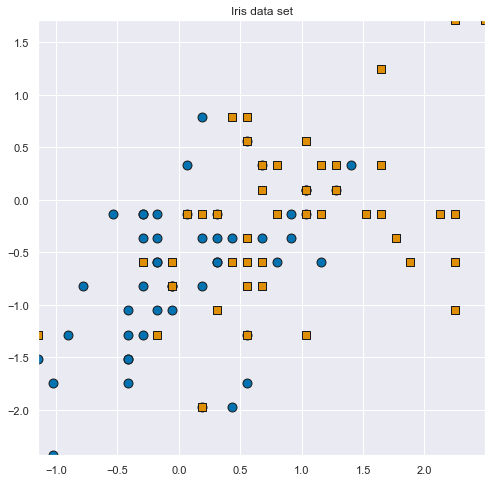

In [2]:
# Importing Iris Data set from sklearn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
iris = datasets.load_iris()
X = iris.data
X = scaler.fit_transform(X)
y = iris.target
X = X[y != 0, :2]
y = y[y != 0]

#plot the data
plt.figure(figsize=(8,8))
plot_2d(X, y)
plt.title('Iris data set')
plt.show()

**Note**:  
One can simply see by ploting the data that the two classes are not linearly separable. It can already be said that a linear kernel will necessarily lead to some misclassifications.

### Linear kernel

Let's try to train the default svm linear kernel model provided by sklearn on the entire data set.

In [3]:
# Linear Kernel
clf_linear = SVC(kernel='linear')
clf_linear.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Without specifying any parameters, we can see that the default regularization term is **C = 1**.

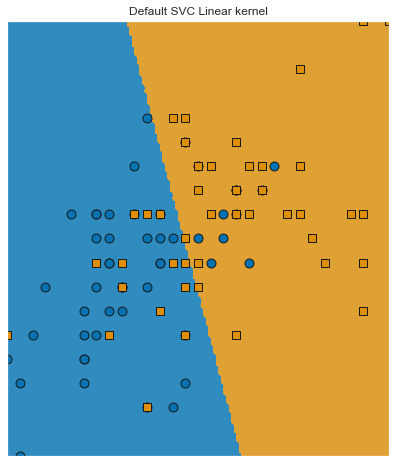

In [4]:
# Plot
plt.figure(figsize=(8,8))
frontiere(clf_linear.predict, X, y, colorbar=False, step=150)
plt.title('Default SVC Linear kernel')
plt.show()

### Using default svm.SVC polynomial kernel

In [5]:
# Polynomial kernel
clf_poly = SVC(kernel='poly', gamma='scale')
clf_poly.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Default degree for SVC polynomial kernel is **d = 3**.

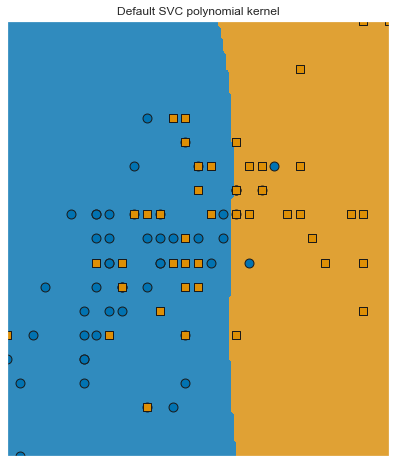

In [6]:
# Plot
plt.figure(figsize=(8,8))
frontiere(clf_poly.predict, X, y, colorbar=False, step=150)
plt.title('Default SVC polynomial kernel')
plt.show()

### Comparing linear kernel to default svm.SVC polynomial kernel  
  
What results do we get with a linear kernel and a polynomial kernel? We can compare the average of the scores obtained on 100 data split.

In [7]:
nb_rep = 100
linear_scores = []
poly_scores = []

# linear and poly kernel functions
clf_linear = SVC(kernel='linear', gamma='scale')
clf_poly = SVC(kernel='poly', gamma='scale')

for k in range(nb_rep):
    # Split wih 50% for train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    clf_linear.fit(X_train, y_train)
    clf_poly.fit(X_train, y_train)
    
    linear_scores.append(clf_linear.score(X_test, y_test))
    poly_scores.append(clf_poly.score(X_test, y_test))

linear_mean_score = np.mean(linear_scores)
poly_mean_score = np.mean(poly_scores)

print('Linear score: {}'.format(linear_mean_score))
print('Poly score: {}'.format(poly_mean_score))

Linear score: 0.6806
Poly score: 0.5854


**Conclusion**:  
Using a more complex model doesn't always provide better results. For a svm method, one should test several kernels, and try to optimize the regularization term and hyperparameters. While doing so, it is also crucial to avoid over-fitting in the choose of the Kernel functions and this regularization term.

### Primal problem reformulation

As we allow some classification mistakes, the primal problem solved by the SVM is expressed as well with slack variables $\xi_i$:  
  
$$\min_{w,w_0} \frac{1}{2}||w||^2 + C \sum_{i=1}^n \xi_i$$  
  
With these constraints:  
  
$$\forall i, y_i(w^T\Phi(x_i)+w_0) \geq 1 - \xi_i $$,  $$\xi_i \ge 0$$  
  
A data point classified correctly will have a slack variable equals to zero: $\xi_i = 0$  
  
For the others, even if we tolerate these slack variables, the optimisation introduced with the primal problem induces them to be as small as possible. That is obtained, with the above constraints, for:  
  
$$\xi_i = 1 - y_i(w^T\Phi(x_i)+w_0)$$  

Thus, for any data point, we can say:  
  
$$\xi_i = \max(0, 1 - y_i(w^T\Phi(x_i)+w_0))$$  

The primal problem can hence be formuled as well:  
  
$$\min_{w,w0} (\frac{1}{2}||w||^2 + C \sum_{i=1}^n[1 - y_i(w^T\Phi(x_i)+w_0)]_+)$$
  
The hinge loss function $ x → [1 − x]_+$ appears in the formula. This function is convex upper bound of the function that equals 1 when the margin is  negative, 0 otherwise.
  
![Hinge function](pictures/Hinge_Loss.PNG)

## Unbalanced data set  
  
Somtimes we may be confronted to a very unbalanced dataset with many points in one class than in the other (at least 90% vs. 10%).  
In this kind of situation, one can observed this phenomenon by reducing the C regularization term:  

$$C=1$$  
![unbalanced and C=1](pictures/unbalanced_highC.PNG)  
$$C=1.5e-3$$
![unbalanced and C=1.5e-3](pictures/unbalanced_lowC.PNG)  
  
The inferior class is found gradually "encompassed" in the other side of the separator hyperplane.  
When C is very little, we tend to get a the largest margin possible without trying to "get everything right". But in this particular unbalacend situation, it results with this problem and too much misclassification.  
  
This phenomenon can be corrected in practice by weighting more the errors on the inferior class (SVC `class_weight` parameter) or by a re-calibration technique (used with `SVC(..., probability = True)`).  
  
![unbalanced weighted](pictures/unbalanced_weighted.PNG)

## Faces classification  
  
We will now use the "Labeled Faces in the Wild" dataset: http://vis-www.cs.umass.edu/lfw/

### Load data set  
  
We will perform a 2 labels classification by selecting the only two faces with more than 150 pictures.

In [8]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=150)
n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 766
n_features: 2914
n_classes: 2


The SVM optimization occurs with the minimization of the decision vector $w$. This is influenced by the scale of the features and a standadization will rescale them all. It leads to a consistantly improved optimization time and provides a better scaled hyperplan.

In [9]:
X = preprocessing.StandardScaler().fit_transform(X)

### Data examples

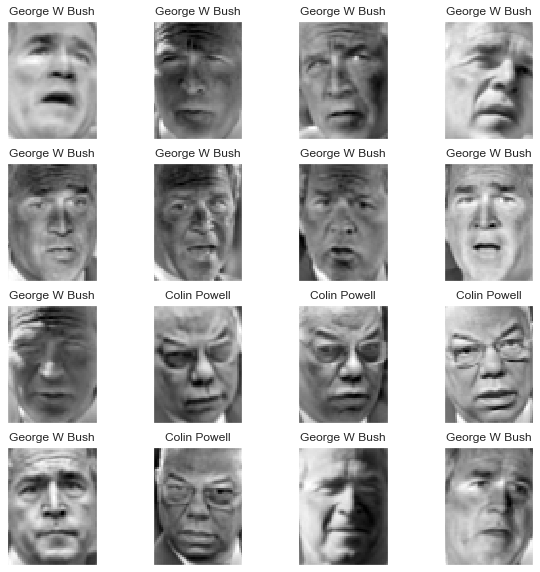

In [10]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(target_names[lfw_people.target[i]], size=12)
    plt.xticks(())
    plt.yticks(())

In [11]:
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

### Influence of regularization C parameter  
  
To observe the influence of the C parameter, we may show the prediction error as a function of C on a logarithmic scale between 1e5 and 1e-5 for example.

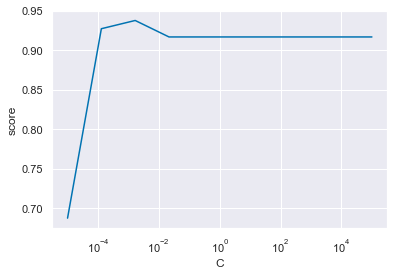

In [12]:
scores = []

# C range to evaluate
C_values = np.logspace(-5, 5, num=10)

# Evaluating prediction score on this range
for C_value in C_values:
    clf = SVC(kernel='linear', C=C_value)
    clf = clf.fit(X_train, y_train)
    scores.append(clf.score(X_test,y_test))

# Plot with log scale
plt.figure()
plt.plot(C_values, scores, '-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('score')
plt.show()

The graphic shows that a low C causes too much misclassification. Progressively the score reaches a maximum for a C around 1e-3. Then higher values give less good results for future predictions, and the hyperplan "stabilizes" itself.  
  
The best C value may be confirmed with by cross validation with a `GridSearchCV`.

In [13]:
# To observe computing time
t0 = time()

# GridSearchCV on C values to find optimal C term
clf = GridSearchCV(SVC(kernel='linear',gamma='scale'), {'C': C_values}, cv=5, iid=False)
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

C_opt = clf.best_params_['C']

print('Optimal C term: {}'.format(C_opt))
print('Score for optimal C: {}'.format(clf.score(X_test,y_test)))

# Prediction with test
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

done in 41.288s
Optimal C term: 0.0016681005372000592
Score for optimal C: 0.9375
               precision    recall  f1-score   support

 Colin Powell       0.91      0.88      0.90        60
George W Bush       0.95      0.96      0.95       132

     accuracy                           0.94       192
    macro avg       0.93      0.92      0.93       192
 weighted avg       0.94      0.94      0.94       192

[[ 53   7]
 [  5 127]]


A similar value to the one predicted with the graphic is found!

### Adding noise features  
  
By adding some nuisance variables (for example, 500 normal centered reduced variables), let's see if there is a performance drop:

In [14]:
# Adding noise features
noise = np.random.randn(X_train.shape[0], 500)
X_train_noise = np.concatenate((X_train, noise), axis=1)

noise = np.random.randn(X_test.shape[0], 500)
X_test_noise = np.concatenate((X_test, noise), axis=1)

# Gridsearch CV for optimal C value
clf = GridSearchCV(SVC(kernel='linear',gamma='scale'), {'C': C_values}, cv=5, iid=False)
clf.fit(X_train_noise, y_train)

C_opt = clf.best_params_['C']

print('Optimal C term: {}'.format(clf.best_params_))
print('Score for optimal C: {}'.format(clf.score(X_test_noise,y_test)))

# Prediction with test
y_pred_noise = clf.predict(X_test_noise)

print(classification_report(y_test, y_pred_noise, target_names=target_names))
print(confusion_matrix(y_test, y_pred_noise, labels=range(n_classes)))

Optimal C term: {'C': 0.0016681005372000592}
Score for optimal C: 0.921875
               precision    recall  f1-score   support

 Colin Powell       0.89      0.85      0.87        60
George W Bush       0.93      0.95      0.94       132

     accuracy                           0.92       192
    macro avg       0.91      0.90      0.91       192
 weighted avg       0.92      0.92      0.92       192

[[ 51   9]
 [  6 126]]


For this data set and the selected two classes (Bush and Powell) that have many samples, the performance with some noise is slightly less good after a cross validation, but not that much.

### PCA prior SVM  
  
We may want to observe the effect of a principal component analysis.

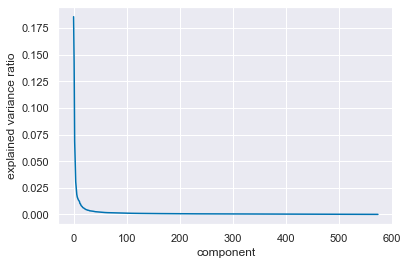

In [15]:
# PCA with all components
pca = PCA().fit(X_train_noise)

plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('component')
plt.ylabel('explained variance ratio')
plt.show()

The graph shows that approximately 70 components explain all the variance. We will keep this value for projecting the input data with the PCA.

In [16]:
# PCA on the face data set 
n_components = 70
pca = PCA(n_components=n_components).fit(X_train_noise)

# Projecting the input data on the eigenfaces orthonormal basis
X_train_pca = pca.transform(X_train_noise)
X_test_pca = pca.transform(X_test_noise)

# To observe computing time
t0 = time()

# GridsearchCV for optimal C value
clf = GridSearchCV(SVC(kernel='linear',gamma='scale'), {'C': C_values}, cv=5, iid=False)
clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))

print('Optimal C term: {}'.format(clf.best_params_))
print('Score for optimal C: {}'.format(clf.score(X_test_pca,y_test)))

# Prediction with test
y_pred_pca = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred_pca, target_names=target_names))
print(confusion_matrix(y_test, y_pred_pca, labels=range(n_classes)))

done in 1.999s
Optimal C term: {'C': 0.0016681005372000592}
Score for optimal C: 0.9427083333333334
               precision    recall  f1-score   support

 Colin Powell       0.93      0.88      0.91        60
George W Bush       0.95      0.97      0.96       132

     accuracy                           0.94       192
    macro avg       0.94      0.93      0.93       192
 weighted avg       0.94      0.94      0.94       192

[[ 53   7]
 [  4 128]]


With a principal component analysis, prediction is now a bit better, even with the noise. There is also a great improvement in computing time!

### Non linear RBF Kernel  
  
What are the results with the RBF Kernel ? A GridsearchCV is useful for finding the optimal C value and the $\gamma$ hyperparameter.

In [17]:
# To observe computing time
t0 = time()

# Search for optimal values for C and hyper parameter gamma
param_grid = {'C': C_values,
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(X_train_pca, y_train)

print('done in %0.3fs' % (time() - t0))
print('Best estimator found by grid search:')
print(clf.best_estimator_)
print('Score:')
print(clf.score(X_test_pca, y_test))

# Prediction with test
y_pred_rbf = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred_rbf, target_names=target_names))
print(confusion_matrix(y_test, y_pred_rbf, labels=range(n_classes)))

done in 16.091s
Best estimator found by grid search:
SVC(C=46.41588833612782, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Score:
0.953125
               precision    recall  f1-score   support

 Colin Powell       0.93      0.92      0.92        60
George W Bush       0.96      0.97      0.97       132

     accuracy                           0.95       192
    macro avg       0.95      0.94      0.95       192
 weighted avg       0.95      0.95      0.95       192

[[ 55   5]
 [  4 128]]


With a non RBF kernel accuracy is close from what we obtained with a linear kernel.